# Geometric Computer Vision (236861) - Assignment 3

## Problem 1

### Solving a Maze

1) Calculate the distances inside the maze supplied with this exercise (maze.png)
using the Fast-Marching Method (FMM) and a source point given by (x, y) =
(814, 383). Treat image boundaries as walls

In [491]:
import matplotlib.pyplot as plt
from PIL import Image

import eikonalfm
import numpy as np

In [492]:
def print_image(image, title, color_bar=False, cmap=False):
    if cmap:
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.title(title)
    if color_bar:
        plt.colorbar()
    plt.show()

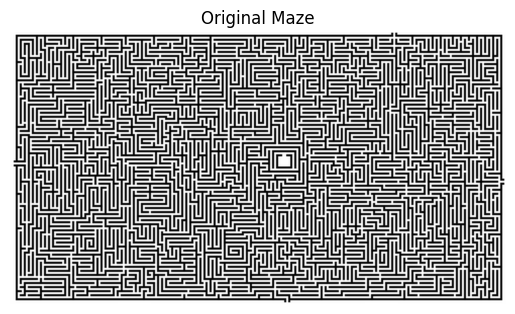

In [493]:
# Load the maze
MAZE_PATH = 'maze.png'
image = np.asarray(Image.open(MAZE_PATH).convert('L'))
image = image / np.max(image)
print_image(image, 'Original Maze', cmap="gray")


In [494]:
THRESHOLD = 0.1
def make_speed_map(gray: np.ndarray, thr: float = THRESHOLD) -> np.ndarray:
    speed = np.ones_like(gray, dtype=float)
    speed[gray > thr] = 1000
    return speed

speed = make_speed_map(image)


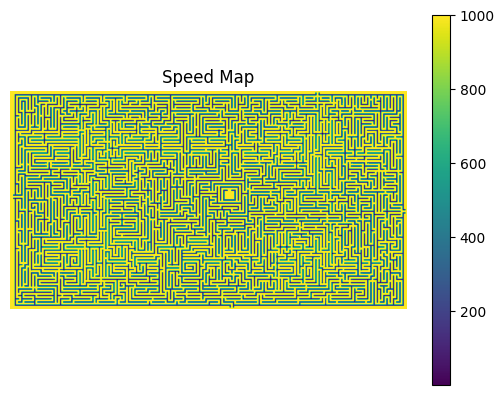

In [495]:
# Plot the speed map
print_image(speed, 'Speed Map', color_bar=True)

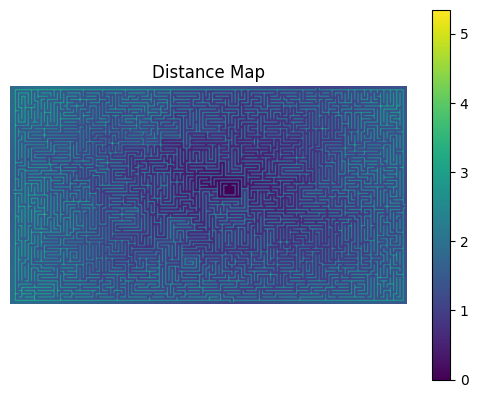

In [496]:
SOURCE_POINT = (383, 814)
distance_map = eikonalfm.fast_marching(speed, SOURCE_POINT, dx=(1,1), order=1)

print_image(distance_map, 'Distance Map', color_bar=True)

2) Find the shortest path from the given source point above to a target point
(8, 233), by following the negative gradient direction of the distance function
from target to source. Use a simple finite differences approximation for the
gradient in the x and y directions. Plot the shortest path on top of the maze
image

In [530]:
def back_trace_shortest_path(distance_map, target: tuple[2], source: tuple[2], L1 = False):
    def check_if_neighbor_is_legal(neighbor, current_vertex):
        if L1 and abs(neighbor[0] - current_vertex[0]) + abs(neighbor[1] - current_vertex[1]) == 2:
            return False
        return 0 <= neighbor[0] < distance_map.shape[0] and 0 <= neighbor[1] < distance_map.shape[1] and neighbor != current_vertex

    path = [target]
    current_vertx = target
    while current_vertx != source:
        closest_val = float('inf')
        neighbors = [(current_vertx[0] + i, current_vertx[1] + j) for i in range(-1, 2) for j in range(-1, 2)]
        for neighbor in neighbors:
            if check_if_neighbor_is_legal(neighbor, current_vertx):
                if distance_map[neighbor[0], neighbor[1]] < closest_val:
                    closest_val = distance_map[neighbor[0], neighbor[1]]
                    next_vertx = neighbor
        current_vertx = next_vertx
        path.append(next_vertx)
    return path

TARGET_POINT = (233, 8)
path = back_trace_shortest_path(distance_map, TARGET_POINT, SOURCE_POINT)

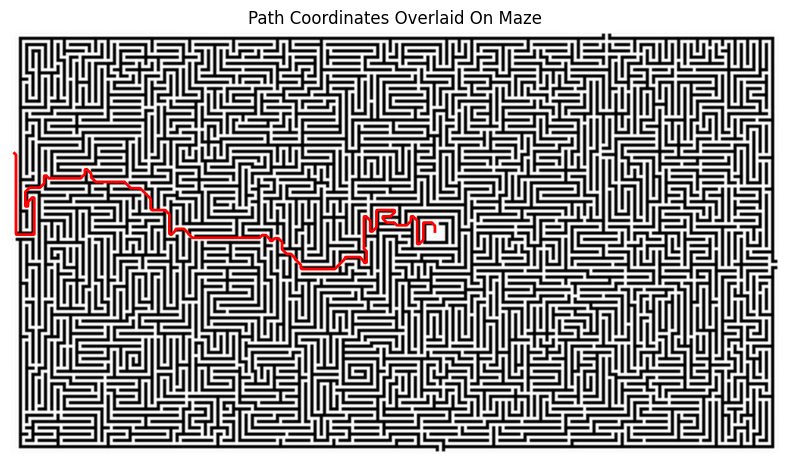

In [535]:
def plot_path_on_image(path, image_path, title = "Maze",  load_from_path = True):
    maze = np.asarray(Image.open(image_path)) if load_from_path else image_path
    ys, xs = zip(*path)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(maze)

    plt.plot(xs, ys, color='red', linewidth=2)
    ax.set_title(f"Path Coordinates Overlaid On {title}")
    ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_path_on_image(path, MAZE_PATH)


* Make sure you receive approximately the same plot and path length if
you rotate the maze image by 45 degrees.

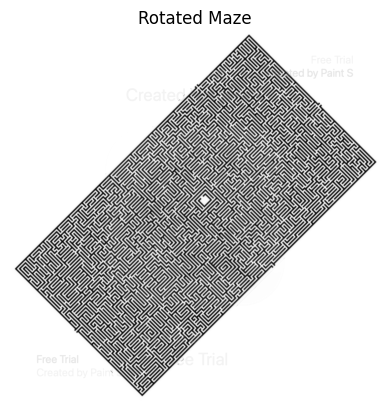

In [505]:
ROTATED_MAZE_PATH = 'rotated maze.png'
rotated_maze = np.asarray(Image.open(ROTATED_MAZE_PATH).convert('L'))
rotated_maze = rotated_maze / np.max(rotated_maze)

print_image(rotated_maze, 'Rotated Maze', color_bar=False, cmap="gray")

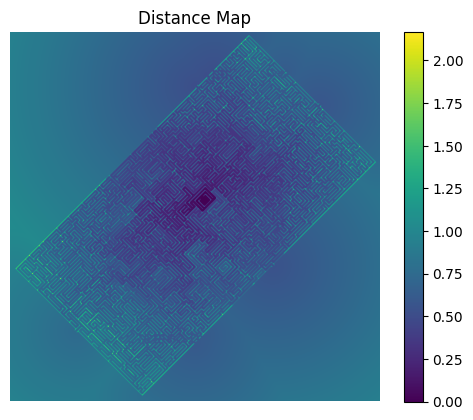

In [501]:
ROTATED_MAZE_SOURCE_POINT = (385,440)

rot_speed = make_speed_map(rotated_maze)
distance_map_rot = eikonalfm.fast_marching(rot_speed, ROTATED_MAZE_SOURCE_POINT, dx=(1,1), order=2)

print_image(distance_map_rot, 'Distance Map', color_bar=True)

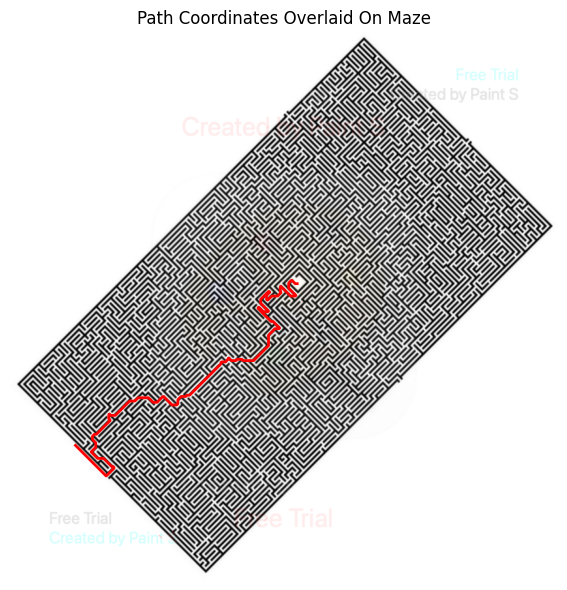

In [504]:
ROTATED_MAZE_TARGET_POINT = (633, 100)
rotated_maze_path = back_trace_shortest_path(distance_map_rot, ROTATED_MAZE_TARGET_POINT, ROTATED_MAZE_SOURCE_POINT)
plot_path_on_image(rotated_maze_path, ROTATED_MAZE_PATH)


### Optical Path

The optical path length (OPL) is defined as the product of the Euclidean length
of the path of light, and the index of refraction of the medium through which it propagates (denoted by n).

$\int_{C}n(s)ds$

Use FMM to calculate the OPL between two points, one inside a pool with water,
with coordinate (x, y) = (400, 500) and one outside, with coordinate (x, y) = (1, 1),
using the indices of refraction given in ’pool.mat’. Plot the shortest path on the top
of the image of the indices of refraction.

dict_keys(['__header__', '__version__', '__globals__', 'n'])


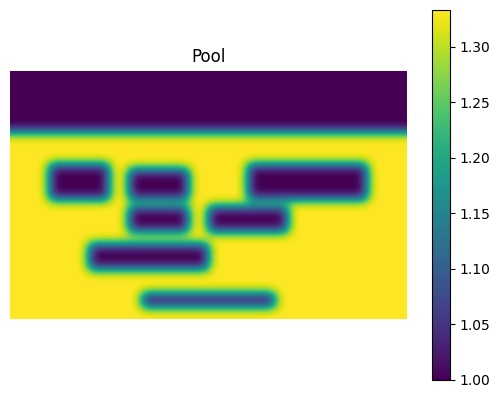

In [529]:
# Load the pool
import scipy.io

POOL_PATH = 'pool.mat'

pool_data = scipy.io.loadmat('pool.mat')
print(pool_data.keys())
pool = pool_data.get('n') #/ np.max(pool_data.get('n'))
print_image(pool, "Pool", color_bar=True)


In [527]:
INSIDE_POOL = (400, 500)
OUTSIDE_POOL = (1, 1)

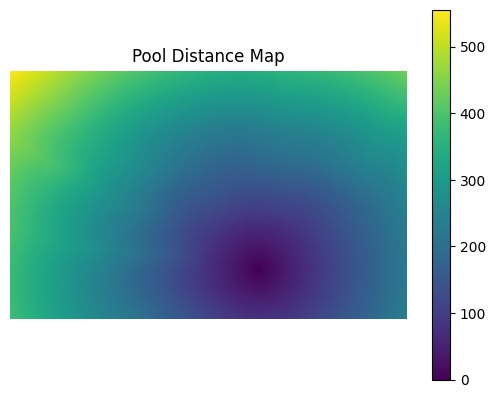

In [536]:
pool_distance_map = eikonalfm.fast_marching(pool_data.get('n'), INSIDE_POOL, dx=(1,1), order=1)
print_image(pool_distance_map, 'Pool Distance Map', color_bar=True)


the OPL depends on the set of legal steps that can be walked.

Let's divide the answer into two:
* The first case presents the OPL given only lattice steps (L1)
* The second case presents the OPL given that it can also be walked on diagonals.

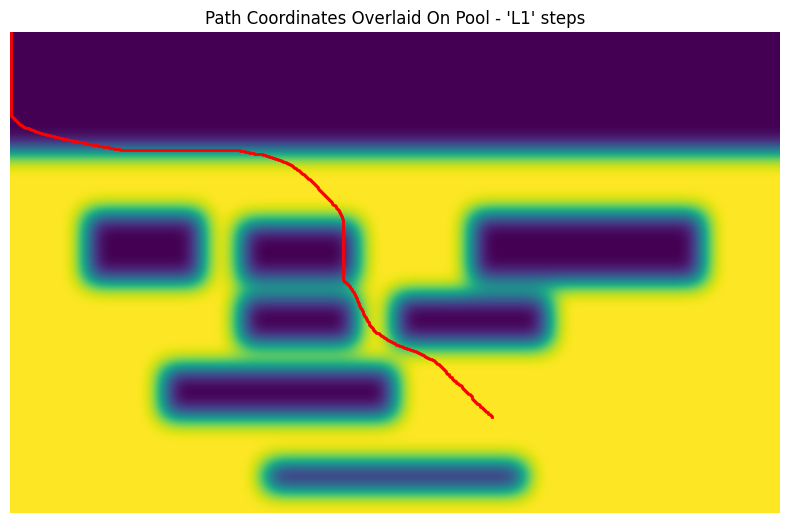

In [538]:
l1_pool_path = back_trace_shortest_path(pool_distance_map, OUTSIDE_POOL, INSIDE_POOL, L1=True)
plot_path_on_image(l1_pool_path, pool_data.get('n'), title="Pool - 'L1' steps", load_from_path=False)


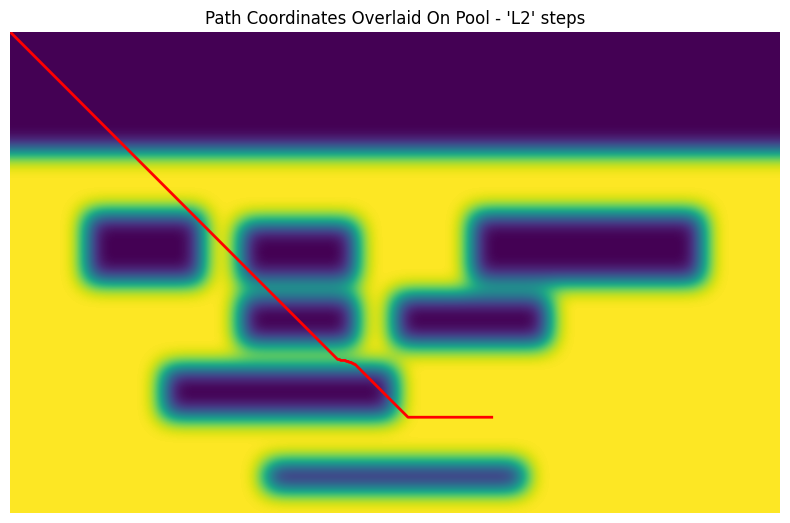

In [539]:
l2_pool_path = back_trace_shortest_path(pool_distance_map, OUTSIDE_POOL, INSIDE_POOL)
plot_path_on_image(l2_pool_path, pool_data.get('n'), title="Pool - 'L2' steps", load_from_path=False)